# Optimising Pristine target selection for WEAVE

*Ruben Sanchez-Janssen (UKATC)*

The goal of this notebook is to explore ways to improve target selection for WEAVE based on the combined Pristine photometric and spectroscopic catalogues, as well as Gaia.

In this first stage we'll inspect the residuals between the Pristine photometric metallicities and the spectroscopic ones from FERRE, using the latest version of the spectroscopic catalogue.

Let's start by reading the data and definining a few useful quantities:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)

In [2]:
df = pd.read_csv('pristine_2019_gaia_dr2.csv')
df['dmet_gi'] = df.FeHphot_gi - df.FERRE_met
df['dmet_gr'] = df.FeHphot_gr - df.FERRE_met 
df['u-g'] = df.u_0 - df.g_0
df['u-r'] = df.u_0 - df.r_0
df['u-i'] = df.u_0 - df.i_0
df['g-i'] = df.g_0 - df.i_0
df['g-r'] = df.g_0 - df.r_0
df['r-i'] = df.r_0 - df.i_0
df['bp-rp'] = df.phot_bp_mean_mag - df.phot_rp_mean_mag
df['gflux_relunc'] = df.phot_g_mean_flux_error / df.phot_g_mean_flux

Now, let's plot the difference between the Pristine and the FERRE metallicities as a function of several parameters that may have an influence on the precision of our estimates. Note that in all cases we require the targets to have good photometric quality flags (as implemented in Youakim+17), as well a reasonable photometric and spectroscopic metallicity estimates--but no other quality selection criteria are implemented. 

In the following panels we show the difference $([Fe/H]_{phot} - [Fe/H]_{FERRE})$ as a function of a selection of the available photometric parameters. The trends as a function of the metallicity estimates using the $(g-i)$ and the $(g-r)$ colours are shown in the top and bottom rows, respectively. In all cases we also plot in orange a lowess estimate of the mean relation to highlight obvious trends.

### Metallicity estimate and probability

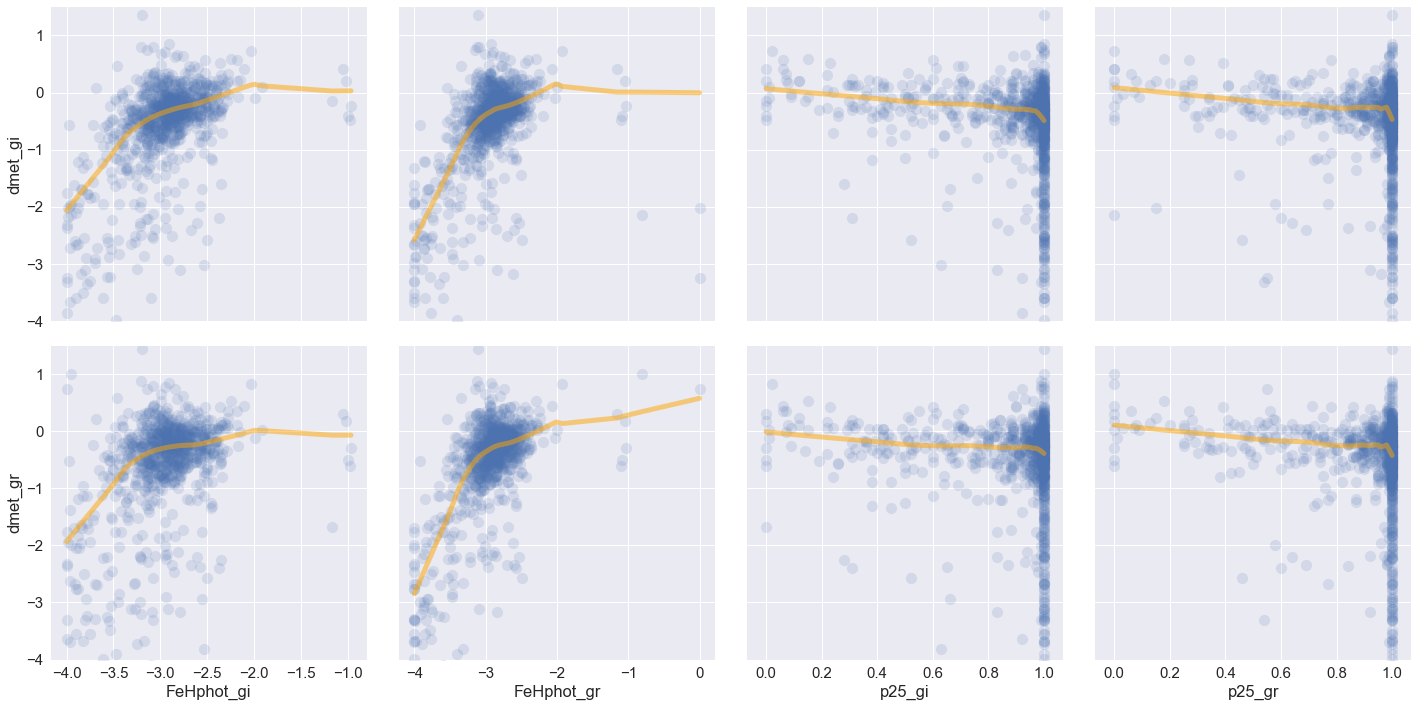

In [3]:
wdf = df.where(
                (df.FeHphot_gi > -5) & (df.FeHphot_gr > -5) & \
                (df.phot_qual_flags == '[]') & (df.KD_flag == 'X')
                )
prob = sns.PairGrid(data=wdf,
                  y_vars=['dmet_gi','dmet_gr'],
                  x_vars=['FeHphot_gi','FeHphot_gr','p25_gi','p25_gr'],
                  size=5
                  )
prob.map(sns.regplot, lowess=True, \
            scatter_kws={'alpha':0.15,'s':125}, line_kws={'color':'orange','alpha':0.5,'lw':5}
            )
prob.set(ylim=(-4.,1.5))

The first two columns show the metallicity difference as a function of photometric metallicity, and the two las columns correspond to the probabilities that they are metal-poor stars. Note that there is a significant tail of stars with P(<-2.5) = 1 that have very large metallicity offsets. These stars are the ones we'd like to identify, but these two parameters do not show an obvious trend with the residual metallicity.

### Colour
Other than the $(g-i)$ and $(g-r)$ colours that are used to infer $T_{eff}$, let's see if the residuals correlate with any other colour:

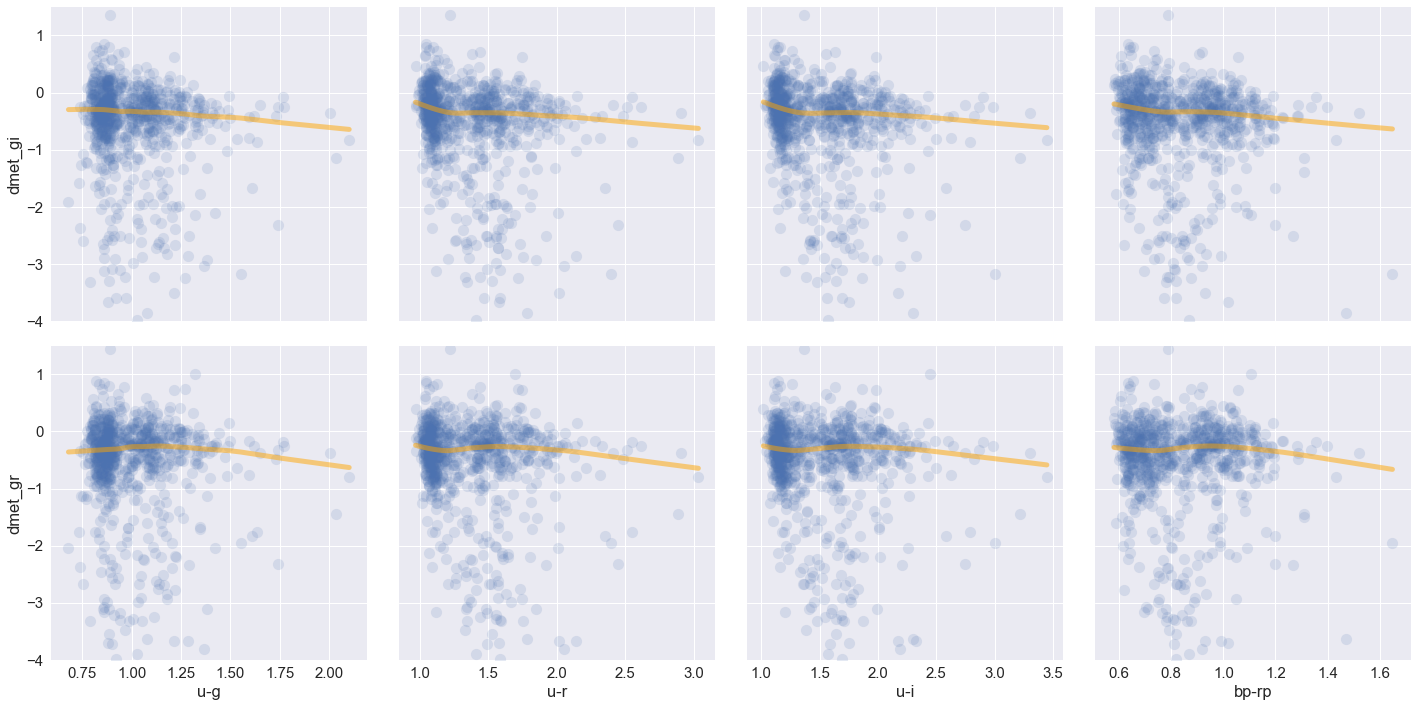

In [4]:
wdf = df.where(
                (df.u_0 > 0.) & (df.g_0 > 0.) & \
                (df.r_0 > 0.) & (df.i_0 > 0.) & \
                (df.FeHphot_gi > -5) & (df.FeHphot_gr > -5) & \
                (df.phot_qual_flags == '[]') & (df.KD_flag == 'X')
                )
colour = sns.PairGrid(data=wdf,
                  y_vars=['dmet_gi','dmet_gr'],
                  x_vars=['u-g','u-r','u-i','bp-rp'],
                  size=5
                  )
colour.map(sns.regplot, lowess=True, \
            scatter_kws={'alpha':0.15,'s':125}, line_kws={'color':'orange','alpha':0.5,'lw':5}
            )
colour.set(ylim=(-4.,1.5))

Other than redder stars having slightly higher offsets (but also, small-number statistics), there isn't much of a trend here. The last column shows the Gaia colours $(B_P-R_P)$.

### Temperature

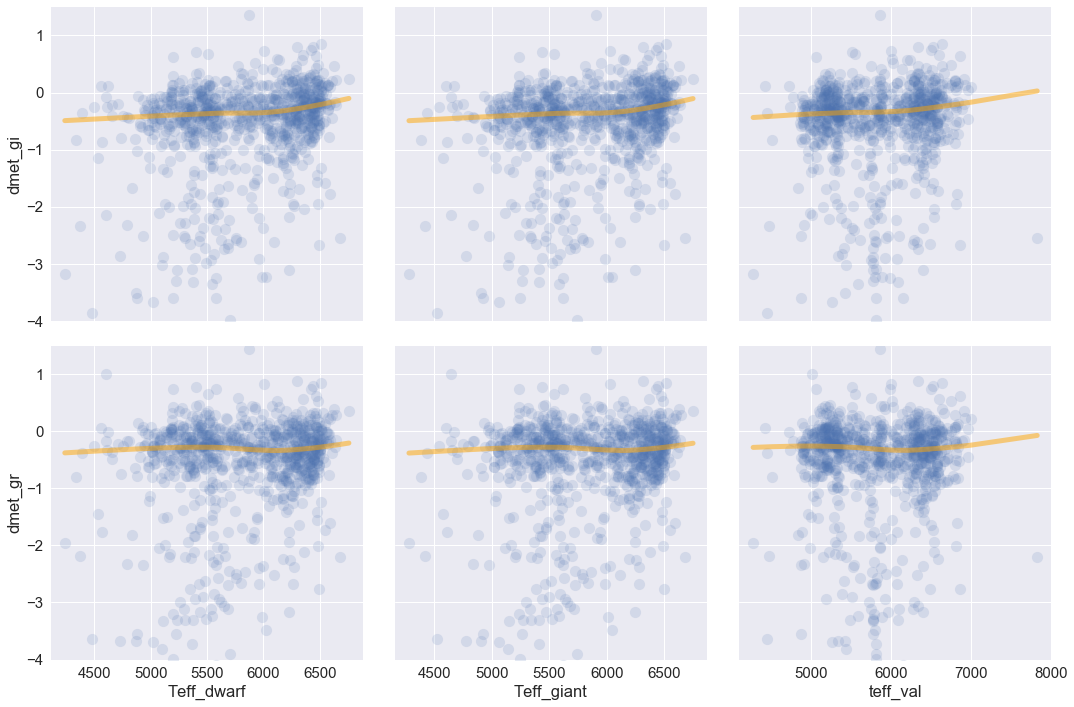

In [5]:
wdf = df.where(
                (df.Teff_dwarf > 4000) & (df.Teff_dwarf < 8000) & \
                (df.Teff_giant > 4000) & (df.Teff_giant < 8000) & \
                (df.FeHphot_gi > -5) & (df.FeHphot_gr > -5) & \
                (df.phot_qual_flags == '[]') & (df.KD_flag == 'X')
                )
teff = sns.PairGrid(data=wdf,
                  y_vars=['dmet_gi','dmet_gr'],
                  x_vars=['Teff_dwarf', 'Teff_giant', 'teff_val'],
                  size=5
                  )
teff.map(sns.regplot, lowess=True, \
            scatter_kws={'alpha':0.15,'s':125}, line_kws={'color':'orange','alpha':0.5,'lw':5}
            )
teff.set(ylim=(-4.,1.5))

These plots do show a trend between the $(g-r)$-based metallicities for the outlier stars, and their $T_{eff}$, independent of whether they're assumed to be dwarfs or giants. The trend is in the sense that cooler stars have the largest offsets. It's clear that the outliers span the full temperature range, so this parameter can't be used on its own. But at least it's informative.  

## Defining boundaries with Machine Learning

It is likely that we will not identify a single parameter that correlates with the offset in metallicity. But perhaps we can use ML algorithms to find non-linear boundaries in a high-dimensional space.

Let's prepare the data. First, we identify the extreme outliers as those departing by more than 1 dex from the spectroscopic metallicity (or roughly $3\sigma$), and using the $(g-i)$ estimate. Because the relation between photometric and spectroscopic metallicity departs from the 1:1.

In [6]:
# Select random subset of filtered data
#filtered.sample(frac=0.7)

#filtered = df.loc[
#                (df.u_0 > 0.) & (df.g_0 > 0.) & \
#                (df.r_0 > 0.) & (df.i_0 > 0.) & \
#                (df.FeHphot_gi > -5) & (df.FeHphot_gr > -5) & \
#                (df.phot_qual_flags == '[]') & (df.KD_flag == 'X')
#                 ]